### Testing Neural Network based Anomaly Detection on simulated data

#### This code generates large dataframe containing multiple timeseries, randomly adds changes in both mean and variance (anomalies), tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

import simulated_data

Using TensorFlow backend.


#### parameters to set

In [2]:
# parameters of simulated data generation
n_series = 6

# lenghts of subject and reference time periods
refh = 12
subh = 1

# probability to correctly classify sample based purely on luck
chance = refh/(subh+refh)
cut = 0.928472 # this is less than 1% chance of random 

print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

# number of training epochs 
epochs=60

chance: 0.9230769230769231 	cut: 0.928472


#### generate normal data

In [3]:
# df =  simulated_data.get_simulated_data()
df =  simulated_data.get_simulated_fixed_data()
df.head()

mean:  [ 0.23086387  0.51582471  0.56651978  0.42169494  0.38018046  0.36357677]
sigma:  [ 0.00357143  0.00833333  0.0125      0.00416667  0.00416667  0.005     ]
affected: [0] 2017-08-02 01:00:00 2017-08-02 02:00:00
affected: [0] 2017-08-03 01:00:00 2017-08-03 04:00:00
affected: [0, 3, 4] 2017-08-04 01:00:00 2017-08-04 02:00:00
affected: [0] 2017-08-05 01:00:00 2017-08-05 02:00:00
affected: [0] 2017-08-06 01:00:00 2017-08-06 04:00:00
affected: [0, 3, 4] 2017-08-07 01:00:00 2017-08-07 02:00:00


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.230178,0.506560,0.554047,0.420541,0.380460,0.359599,0
2017-08-01 00:00:01,0.229532,0.521725,0.577484,0.421780,0.375597,0.369415,0
2017-08-01 00:00:02,0.228173,0.512503,0.562112,0.427291,0.385642,0.360890,0
2017-08-01 00:00:03,0.220974,0.520249,0.580333,0.423265,0.375781,0.370157,0
2017-08-01 00:00:04,0.231178,0.519124,0.578206,0.422570,0.373971,0.354588,0


#### plot timeseries

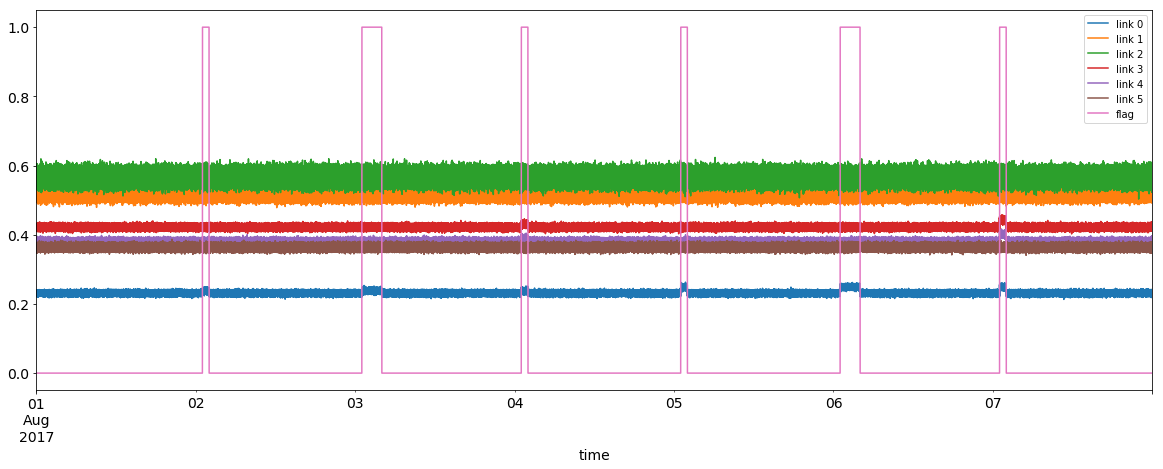

In [4]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)

#### create NN

In [5]:
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
    model.add(Dense(units=n_series*2, activation='relu'))    
#         model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid') )
    
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### This function actually checks for anomaly in one time window. It receives both referent period and subject period (one under investigation). If splits in samples in training and testing parts, shuffle them and trains model. If anomaly has been detected it plots ROC. It returns both loss and accuracy.

In [6]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=epochs, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
        
    return loss_and_metrics[1]

#### Looping over time intervals

0
13376/14040 [===========================>..] - ETA: 0s
 2017-08-01 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 36.84964680671692
1
13504/14040 [===========================>..] - ETA: 0s
 2017-08-01 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.28859615325928
2
12960/14040 [==========================>...] - ETA: 0s
 2017-08-01 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 31.058445930480957
3
13920/14040 [============================>.] - ETA: 0s
 2017-08-01 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 31.90204381942749
4
13504/14040 [===========================>..] - ETA: 0s
 2017-08-01 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 31.222728967666626
5
13760/14040 [============================>.] - ETA: 0s
 2017-08-01 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 32.575124979019165
6
14040/14040 [==============================] - 0s     

 2017-08-

13856/14040 [============================>.] - ETA: 0s
 2017-08-03 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 40.36867308616638
54
13888/14040 [============================>.] - ETA: 0s
 2017-08-03 19:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 40.69232749938965
55
13664/14040 [============================>.] - ETA: 0s
 2017-08-03 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 40.993436336517334
56
13408/14040 [===========================>..] - ETA: 0s
 2017-08-03 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 40.77449679374695
57
13856/14040 [============================>.] - ETA: 0s
 2017-08-03 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.3192195892334
58
13920/14040 [============================>.] - ETA: 0s
 2017-08-03 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.264214754104614
59
13888/14040 [============================>.] - ETA: 0s
 2017-08

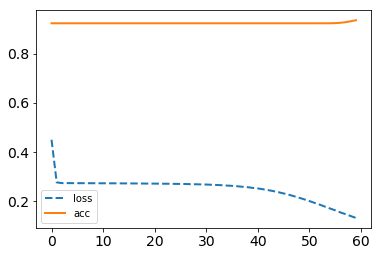


 2017-08-05 02:00:00 	refes: 43200 	subjects: 3600 	score: 0.931054131058
took: 38.255497455596924
86
13792/14040 [============================>.] - ETA: 0s
 2017-08-05 03:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 36.86211824417114
87
13792/14040 [============================>.] - ETA: 0s
 2017-08-05 04:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.4070782661438
88
13440/14040 [===========================>..] - ETA: 0s
 2017-08-05 05:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.6531765460968
89
13664/14040 [============================>.] - ETA: 0s
 2017-08-05 06:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.956139087677
90
13984/14040 [============================>.] - ETA: 0s
 2017-08-05 07:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 43.68863224983215
91
13696/14040 [============================>.] - ETA: 0s
 2017-08-05 08:00:00 	refes: 43200 	subjects: 3600 	score: 0.92307

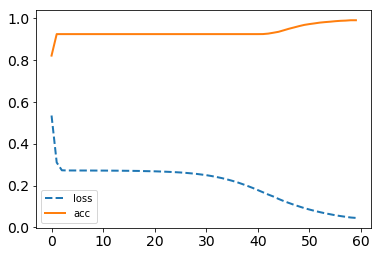


 2017-08-06 02:00:00 	refes: 43200 	subjects: 3600 	score: 0.993091168125
took: 45.34410786628723
110
13760/14040 [============================>.] - ETA: 0s
 2017-08-06 03:00:00 	refes: 43200 	subjects: 3600 	score: 0.92357549858
took: 45.58594512939453
111
13920/14040 [============================>.] - ETA: 0s
 2017-08-06 04:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 44.59642696380615
112
13920/14040 [============================>.] - ETA: 0s
 2017-08-06 05:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 44.06398320198059
113
13440/14040 [===========================>..] - ETA: 0s
 2017-08-06 06:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 44.55274438858032
114
13728/14040 [============================>.] - ETA: 0s
 2017-08-06 07:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 44.124921798706055
115
13888/14040 [============================>.] - ETA: 0s
 2017-08-06 08:00:00 	refes: 43200 	subjects: 3600 	score

In [7]:
df['score']=0.5

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
    endt=time()
    print("took:", endt-startt)
#     if count>2: break
    


#### Plots all the series, now it includes AUC values

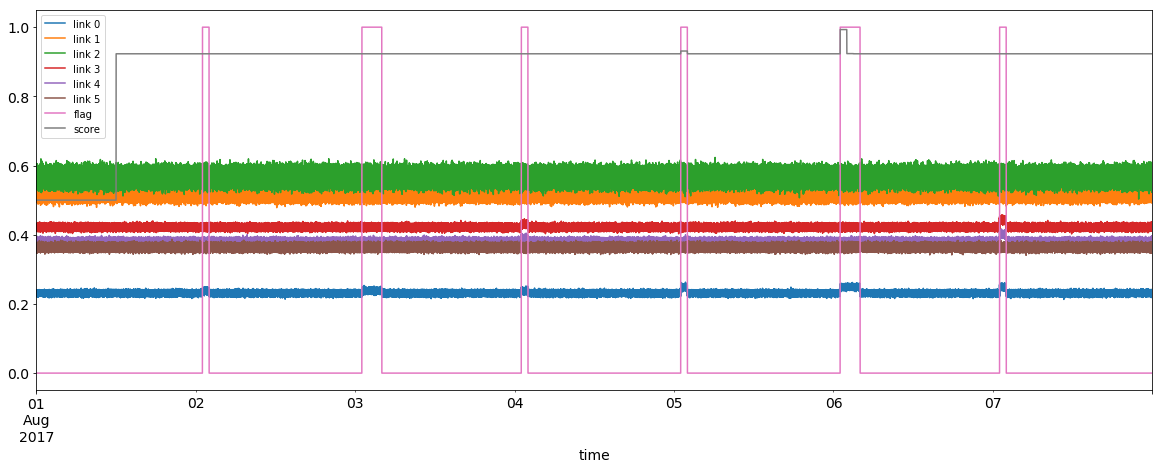

In [8]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
plt.savefig('ANN_simulated_score.png')

#### Plots auc and shades periods were anomaly has been detected

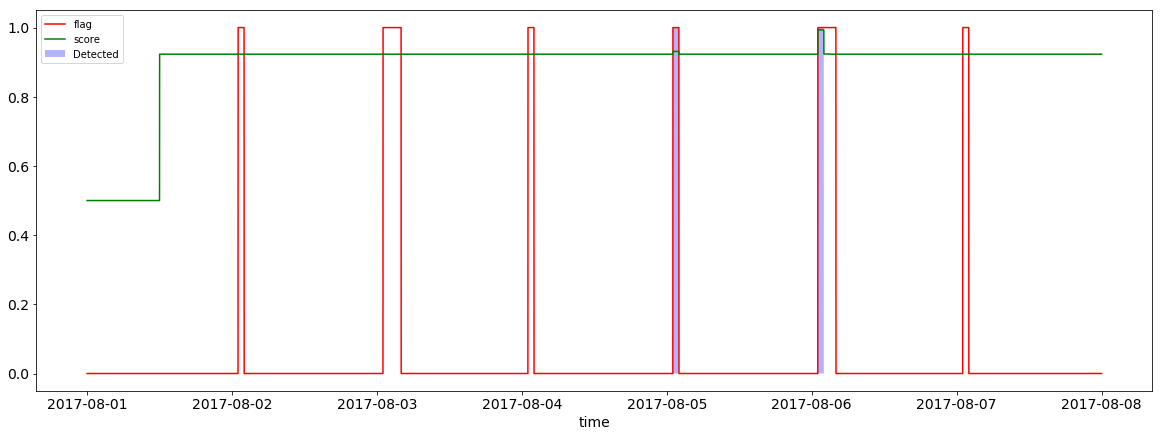

In [9]:
fig, ax = plt.subplots(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()
fig.savefig('ANN_simulated_shaded.png')